<a href="https://colab.research.google.com/github/nhatminh-it/fruits_classification/blob/master/eval_edgecluster_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import các thư viện cần thiết

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

## Nhận dataframe từ drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Tạo model sử dụng canny edge trên ảnh gốc 

In [ ]:
def Ori_Canny (img):
    resized = cv2.resize(img, (200, 200))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edge = cv2.Canny (blur, 70, 50)
    return edge

tạo tập train và valid từ dataframe đã tạo

In [ ]:
train_edge = pd.read_csv('/content/drive/My Drive/Fruit recognition/output_input/25_canny_features_train.csv')
valid_edge = pd.read_csv ('/content/drive/My Drive/Fruit recognition/output_input/25_canny_features_test.csv')

In [ ]:
label_train_edge = train_edge['name']
features_train_edge = train_edge.drop(['name'], axis = 1)
label_valid_edge = valid_edge['name']
features_valid_edge = valid_edge.drop(['name'], axis = 1)

đánh giá các thuật toán tốt nhất

In [ ]:
models = []
models.append(('rfc', RandomForestClassifier()))
models.append(('svc', SVC()))

for name, model in models:
  print(name)
  model.fit(features_train_edge, label_train_edge)
  pred = model.predict(features_valid_edge)
  print('\ttest', accuracy_score(label_valid_edge, pred))

rfc
	test 0.7746031746031746
svc
	test 0.8047619047619048


như vậy svc tốt hơn rfc 

## Đánh giá model sử dụng cluster màu và cả canny edge

In [ ]:
def clustering_image(img):
  #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))
  return result_image, center

In [ ]:
def remove_light_color(img, center_color):
  light_color = max(sum(center_color[0]), sum(center_color[1]))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if sum(img[x][y]) == light_color:
        img[x][y][0]=0
        img[x][y][1]=0
        img[x][y][2]=0
  return img

tạo hàm chuyển canny từ cluster image

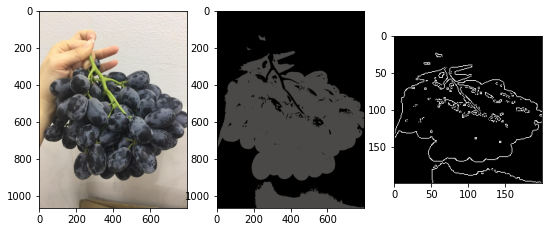

In [ ]:
def Clus_Canny(img):
    resized = cv2.resize(img, (200, 200))
    resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    image, center = clustering_image(resized )
    image = remove_light_color(image, center)
    edge = cv2.Canny(image, 50, 70)
    return edge
# test thử canny với 1 ảnh 
img = cv2.imread ("/content/drive/My Drive/Fruit recognition/valid data /nho/nho_17.jpg")
clus = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image, center = clustering_image(clus)
image = remove_light_color(image, center)
figure_size = 9
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,3,1)
plt.imshow(clus)
plt.subplot(1,3,2)
plt.imshow(image)
plt.subplot(1,3,3)
plt.imshow(Clus_Canny(img), cmap='gray')
plt.show()

In [ ]:
def features_section(img):
    features = np.array([], dtype='uint8')
    section = 1
    
    for y in range(0, img.shape[0], 40):
        for x in range(0, img.shape[1], 40):
            
            # Crop ảnh thành các vùng 40 * 40
            section_img = img[y:y+40, x:x+40]
            
            # tính trung bình và độ lệch chuẩn của các giá trị pixel cho từng vùng
            section_mean = np.mean(section_img)
            section_std = np.std(section_img)
            
            # tạo features 
            features = np.append(features, [section_mean, section_std])
    
    return features

đánh giá tìm ra thuật toán tốt nhất 

In [ ]:
train_clus_edge = pd.read_csv('/content/drive/My Drive/Fruit recognition/output_input/25_edge+cluster_train_features.csv')
valid_clus_edge = pd.read_csv('/content/drive/My Drive/Fruit recognition/output_input/25_edge+cluster_valid_features.csv')

In [ ]:
label_train_cl_ed = train_clus_edge['name']
features_train_cl_ed = train_clus_edge.drop(['name'], axis = 1)
label_valid_cl_ed = valid_clus_edge['name']
features_valid_cl_ed = valid_clus_edge.drop(['name'], axis = 1)

In [ ]:
models_cl_ed = []
models_cl_ed.append(('rfc', RandomForestClassifier()))
models_cl_ed.append(('svc', SVC()))

for name, model in models_cl_ed:
  print(name)
  model.fit(features_train_cl_ed, label_train_cl_ed)
  pred = model.predict(features_valid_cl_ed)
  print('\ttest', accuracy_score(label_valid_cl_ed, pred))

rfc
	test 0.7142857142857143
svc
	test 0.6984126984126984


có thể thấy rfc cho ra kết quả tốt hơn 

## kiểm tra độ chính xác của model đối với tập test data

test với model cluster màu + Canny edge

tạo hàm chuyển ảnh sang dataframe

In [ ]:
def create_df_with_one_image(img):
  feature_name = []
  section = 1
  for y in range(0, 200, 40):
      for x in range(0, 200, 40):
          feature_name.append(f"sec{section}_mean")
          feature_name.append(f"sec{section}_std")
          section += 1
  
  all_imgs = np.zeros((1, 50), dtype='uint8')

  name = []
  section_mean = []
  section_std = []

  img = Clus_Canny(img)

  img_features = features_section(img)
  img_features = img_features.reshape(1, img_features.shape[0])

  all_imgs = np.append(all_imgs, img_features, axis=0)
  all_imgs = all_imgs[1:]

  df = pd.DataFrame(all_imgs, columns= feature_name)
  return df

sử dụng test data để đánh giá model hoạt động trong thực tế 

In [ ]:
path = '/content/drive/My Drive/Fruit recognition/valid data '
file_name = os.listdir(path)
all_25 = 0
total_wrong_25 = 0
for name in file_name:
  total = 0
  wrong = 0
  print(name)
  for image in os.listdir(path+'/'+name):
    #print(path+'/'+name+'/'+image)
    img = cv2.imread(path+'/'+name+'/'+image)
    resized_img = cv2.resize(img, (200, 200))
    resized_img = cv2.cvtColor(resized_img,cv2.COLOR_BGR2RGB)

    final_df = create_df_with_one_image(resized_img)

    predicted_label = models_cl_ed[1][1].predict(final_df)
    if predicted_label != name:
      wrong+=1
    total+=1

    figure_size = 6
    plt.figure(figsize=(figure_size,figure_size))

    plt.subplot(1,2,1)
    plt.imshow(resized_img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(1,2,2)
    plt.imshow(Clus_Canny(resized_img))
    plt.title('true: {}-predicted:{}'.format(name, predicted_label)), plt.xticks([]), plt.yticks([])

    plt.show()
  print('{}/{} wrong'.format(wrong, total))
  total_wrong_25 += wrong
  all_25 += total
print (total_wrong_25)

đánh giá model sử dụng canny edge với ảnh gốc 

In [ ]:
def create_df_with_one_image_edge(img):
  feature_name = []
  section = 1
  for y in range(0, 200, 40):
      for x in range(0, 200, 40):
          feature_name.append(f"sec{section}_mean")
          feature_name.append(f"sec{section}_std")
          section += 1
  
  all_imgs = np.zeros((1, 50), dtype='uint8')

  name = []
  section_mean = []
  section_std = []

  img = Ori_Canny(img)

  img_features = features_section(img)
  img_features = img_features.reshape(1, img_features.shape[0])

  all_imgs = np.append(all_imgs, img_features, axis=0)
  all_imgs = all_imgs[1:]

  df = pd.DataFrame(all_imgs, columns= feature_name)
  return df

In [ ]:
path = '/content/drive/My Drive/Fruit recognition/valid data '
file_name = os.listdir(path)
all_25 = 0
total_wrong_25 = 0
for name in file_name:
  total = 0
  wrong = 0
  print(name)
  for image in os.listdir(path+'/'+name):
    img = cv2.imread(path+'/'+name+'/'+image)
    resized_img = cv2.resize(img, (200, 200))
    #resized_img = cv2.cvtColor(resized_img,cv2.COLOR_BGR2RGB)

    final_df = create_df_with_one_image_edge(resized_img)

    predicted_label = models[2][1].predict(final_df)
    if predicted_label != name:
      wrong+=1
    total+=1

    figure_size = 6
    plt.figure(figsize=(figure_size,figure_size))

    plt.subplot(1,2,1)
    plt.imshow(resized_img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(1,2,2)
    plt.imshow(Ori_Canny(resized_img))
    plt.title('true: {}-predicted:{}'.format(name, predicted_label)), plt.xticks([]), plt.yticks([])

    plt.show()
  print('{}/{} wrong'.format(wrong, total))
  total_wrong_25 += wrong
  all_25 += total
print (total_wrong_25)

## tổng kết: 
sử dụng Canny edge với ảnh gốc:

- random forest classify:

    test accuraccy: 0.7746031746031746
- svc:

	test accuraccy: 0.8047619047619048

sử dụng Canny edge với ảnh sau khi xử lý qua cluster 2 màu:

- random forest classify:

    test accuraccy: 0.7142857142857143
- svc:

	test accuraccy: 0.6984126984126984

**Tổng quan, có thể nhận định xử lý Canny edge với ảnh gốc cho ra accuraccy cao hơn so với sử dụng canny edge sau khi cluster.**
